## TODO

- generalise zodat je niet meer lijsten met namen van de Ca NIR triplet lines hebt

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools

from tqdm import tqdm
from math import prod

# Custom made CaNARY scripts below
import radiative_transfer as rt
import canary_helper_functions as chf

In [2]:
# Constants 
c = 2.99792*10**5     # Speed of light [km/s]

## General inputs

In [3]:
#===============================================================================
# Fill in the input- and lineparameters here

N_mc = 10**5 # Number of MC photon packets to simulate. Default 10**6, for tests 10**5 is fine

T = 5000 # Temperature in the relevant zone. Only used for thermal broadening and exact choice of T should thus not matter much.
v_lim = 10 # photospheric radius, [kms]. Default: 10. Should be > 0. Please do not change for now
wlmin = 8200 # The minimum wl [Å] of the considered grid. Default 8200 
wlmax = 9100 # The maximum wl [Å] of the considered grid. Default 9100 
central_resolution = 10000 # Define the desired central resolution R = delta_wl / wl

line_shape = 'parabola' # can be 'parabola' or 'gaussian'. Default 'parabola'

verbose = True # Plot and print a lot of output during the run

save_profiles = True # Do you want to actually save these profiles?

## Line selection

In the cell below, one can define which lines should be included in the simulation. You can add your own lines of interest in any way you want. In the Barmentloo+25 paper, the present lines were:
1 O I 8446,
2 Ca II 8498,
3 Ca II 8542,
4 Ca II 8662,
5 C I 8727,
6 Mg I 8806,

The first four were assumed to be optically thick at all times. On the contrary, C I 8727 was assumed to always be optically thin. Finally, Mg I 8806 was allowed to vary its optical depth from 0 to 2.

In [4]:
# Lines are defined as lists, where each list element means the following:
# el 0: rest wavelength  
# el 1: transition strength A [s^-1]
# el 2: is the line optically thick? (This is overruled if a 'tau_[line_n]_list' exists, see following cell)

line_1_OI_8446 = [8446, False]
line_2_CaII_8498 = [8498, True]
line_3_CaII_8542 = [8542, True]
line_4_CaII_8662 = [8662, True]
line_5_CI_8727 = [8727, False]
line_6_MgI_8806 = [8806, False]

#CARE these must be sorted by increasing wl!
lines_list = [line_1_OI_8446, line_2_CaII_8498, line_3_CaII_8542, line_4_CaII_8662, line_5_CI_8727, line_6_MgI_8806] 
N_lines = len(lines_list)

Here, one can enter which combinations of line velocity and line luminosity one would like to test. 

Line velocity is a single velocity for all lines. The line luminosity is a number that is defined in a relative way. Its only meaning is thus relative to the sum of all line luminosities. For each possible combination of the lists below, the code will generate a line profile and store it in the 'profile_library' folder. The file name of this profile is defined in 'canary_helper_functions.py'.

In [8]:
# The free parameters

v_outs = np.arange(3000, 6001, 1000) # The velocity above which photons escape (effectively the line width)

# Below, define the relative luminosities (i.e. probabilities of a photon starting with that wl) of the lines.
# (the code will renormalise by summing all and dividing each P by that sum, so that P_tot becomes 1)
# Ordering is again in wl order (just as above)
P_line_1_list = [0]  
P_line_2_list = [1]
P_line_3_list = [1]
P_line_4_list = [1]
P_line_5_list = [3, 5, 7, 10]
P_line_6_list = [0]

# In case you want to vary the optical depth of a certain line, create such a list here. 
# Ordering is again in wl order (just as above)
# If not desired, create a list for that line with a single element set to None
# Put at most 1 decimal place
tau_line_1_list = [None]
tau_line_2_list = [None]
tau_line_3_list = [None]
tau_line_4_list = [None]
tau_line_5_list = [None]
tau_line_6_list = [0, 1, 2]


master_list = [v_outs,
               P_line_1_list, P_line_2_list, P_line_3_list, P_line_4_list, P_line_5_list, P_line_6_list,
              tau_line_1_list, tau_line_2_list, tau_line_3_list, tau_line_4_list, tau_line_5_list, tau_line_6_list]

## Code start

The code starts working below, you should not have to change anything here!

In [9]:
# Initialize arrays that will be used in the Monte Carlo routine
tau_vec = np.zeros(N_lines) # Define a vector with optical depths for each line
wllines = np.zeros(N_lines) # Define a wavelength vector
destrprob = np.zeros(N_lines) # Define a destruction probability vector

for i in range(N_lines): # For each line
    if lines_list[i][1] == True: # If line is optically thick
        tau_vec[i] = 10**10 # Set optical depth to effectively infinity
    else: # If optically thin
        tau_vec[i] = 10**-10 # Set optical depth to effectively 0
        
    wllines[i] = lines_list[i][0]
    destrprob[i] = 0 # Currently only set to 0. This means photons can only scatter, not be absorbed. Might improve in the future
    
    
# Given the desired resolution, calculate the wavelength array
delta_wl = ( (wlmax + wlmin)/2 ) / central_resolution 
binarr = np.arange(wlmin,wlmax,delta_wl)
N_bin = len(binarr)

You requested a total of  48  line profiles to be created. Starting now!


0it [00:00, ?it/s]

The following profile is now being created:


v_out: 3000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 50.0% 
Line 6: 8806.0 Å, tau = 0.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


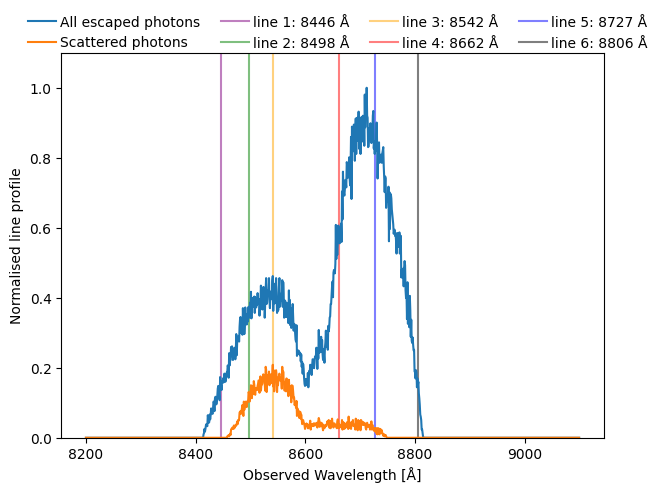

1it [00:03,  3.30s/it]

The following profile is now being created:


v_out: 3000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 50.0% 
Line 6: 8806.0 Å, tau = 1.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


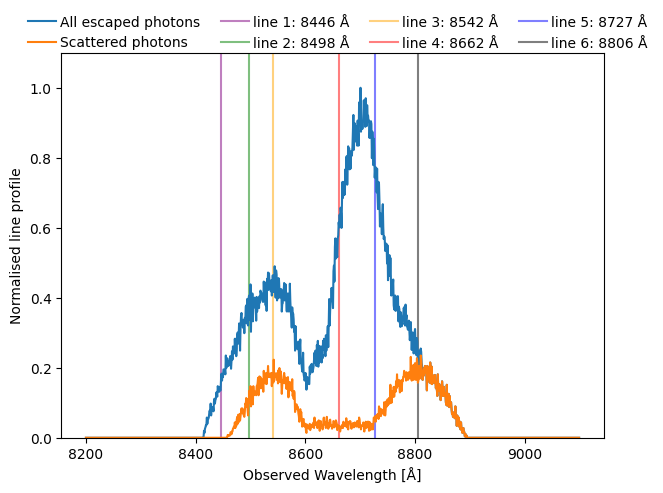

2it [00:06,  3.30s/it]

The following profile is now being created:


v_out: 3000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 50.0% 
Line 6: 8806.0 Å, tau = 2.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


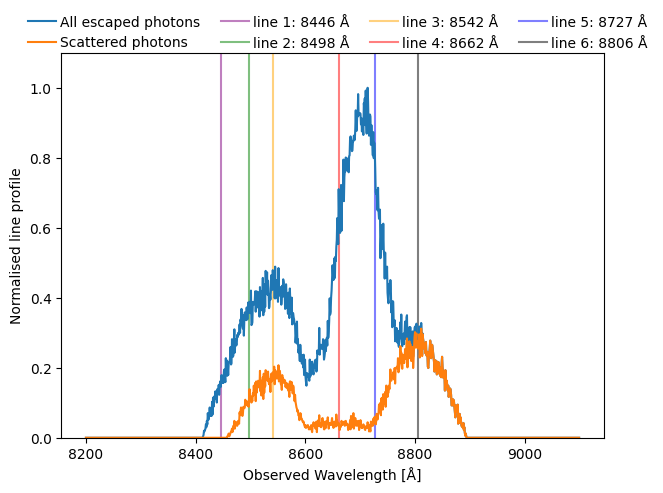

3it [00:09,  3.31s/it]

The following profile is now being created:


v_out: 3000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 62.5% 
Line 6: 8806.0 Å, tau = 0.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


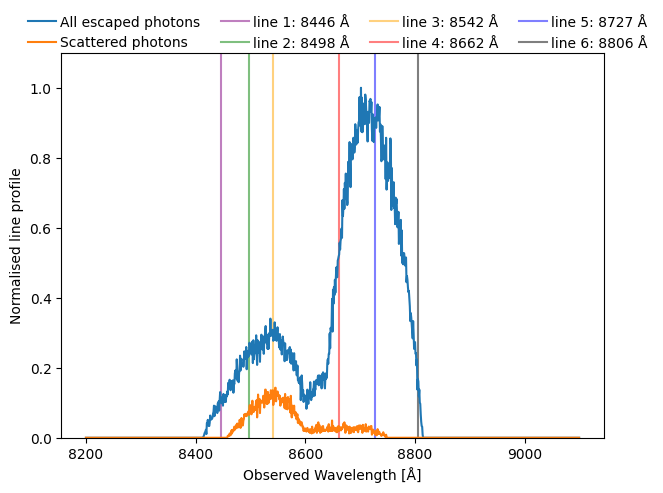

4it [00:14,  3.99s/it]

The following profile is now being created:


v_out: 3000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 62.5% 
Line 6: 8806.0 Å, tau = 1.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


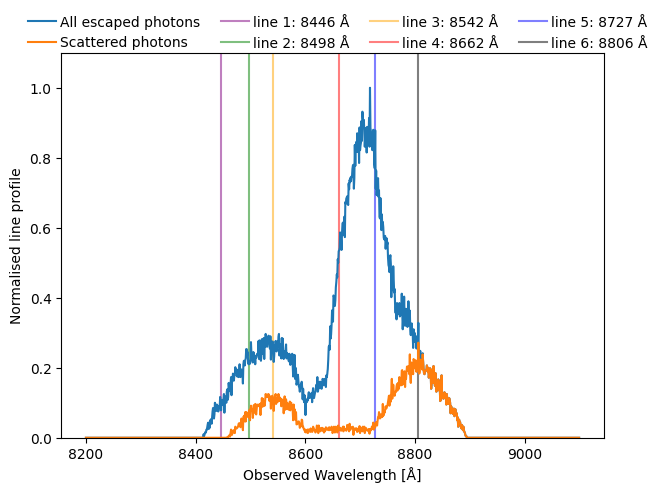

5it [00:19,  4.34s/it]

The following profile is now being created:


v_out: 3000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 62.5% 
Line 6: 8806.0 Å, tau = 2.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


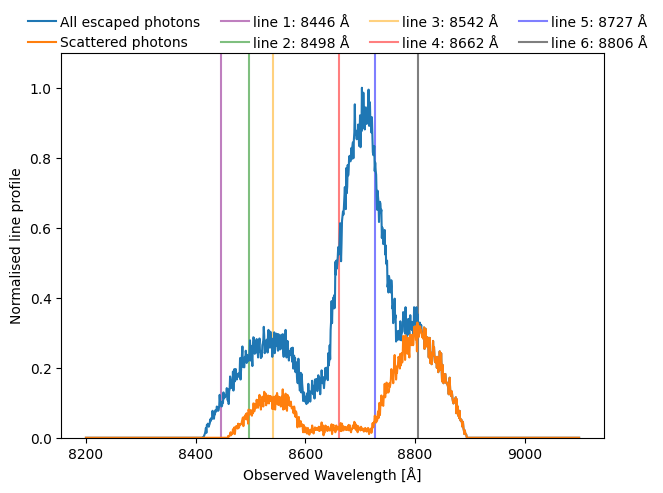

6it [00:25,  4.71s/it]

The following profile is now being created:


v_out: 3000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 70.0% 
Line 6: 8806.0 Å, tau = 0.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


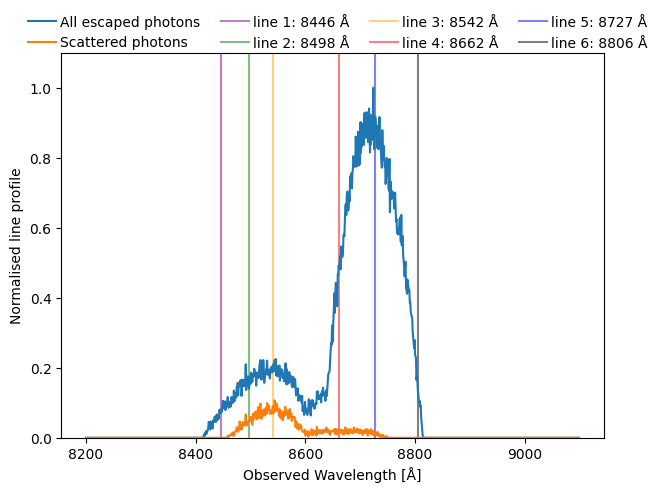

7it [00:30,  4.89s/it]

The following profile is now being created:


v_out: 3000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 70.0% 
Line 6: 8806.0 Å, tau = 1.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


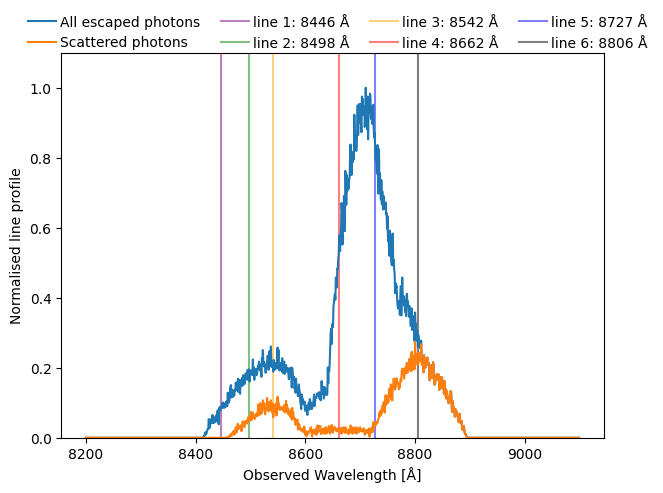

8it [00:35,  4.96s/it]

The following profile is now being created:


v_out: 3000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 70.0% 
Line 6: 8806.0 Å, tau = 2.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


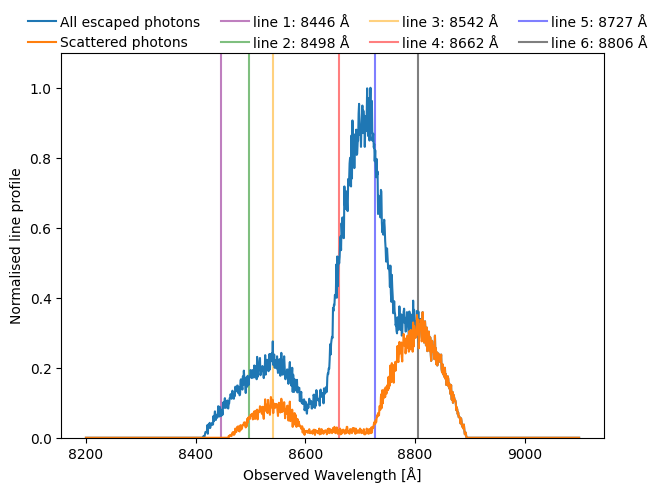

9it [00:41,  5.11s/it]

The following profile is now being created:


v_out: 3000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 76.9% 
Line 6: 8806.0 Å, tau = 0.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


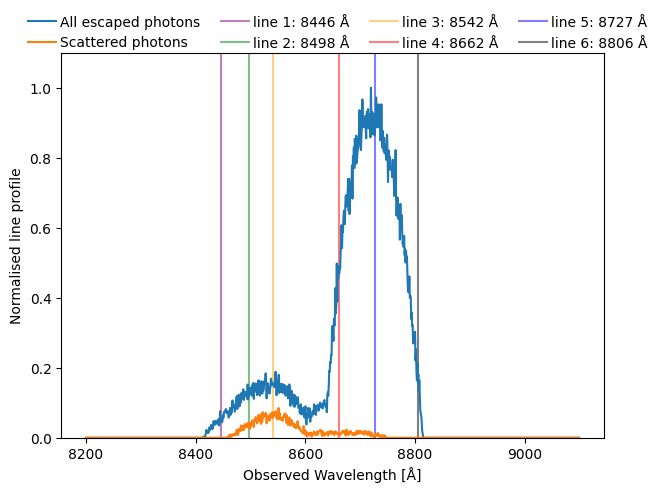

10it [00:46,  5.14s/it]

The following profile is now being created:


v_out: 3000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 76.9% 
Line 6: 8806.0 Å, tau = 1.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


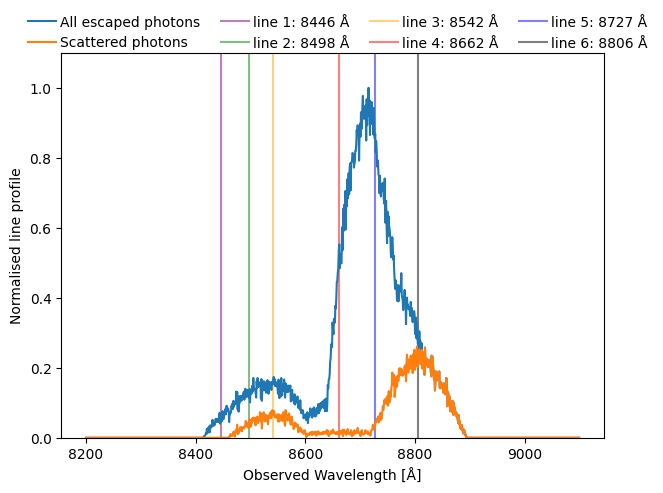

11it [00:51,  5.05s/it]

The following profile is now being created:


v_out: 3000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 76.9% 
Line 6: 8806.0 Å, tau = 2.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


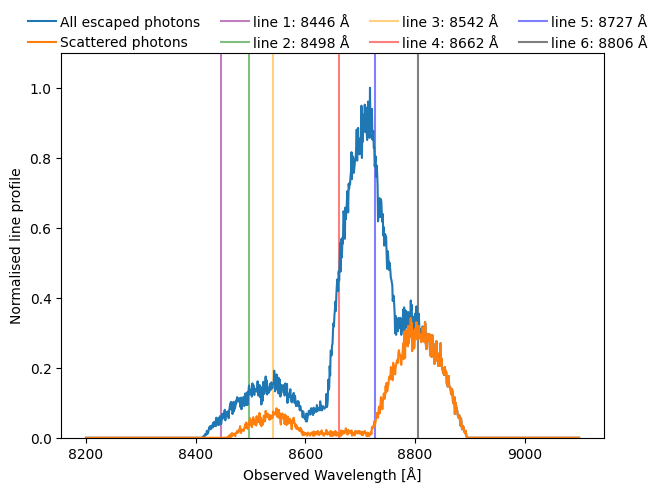

12it [00:55,  4.94s/it]

The following profile is now being created:


v_out: 4000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 50.0% 
Line 6: 8806.0 Å, tau = 0.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


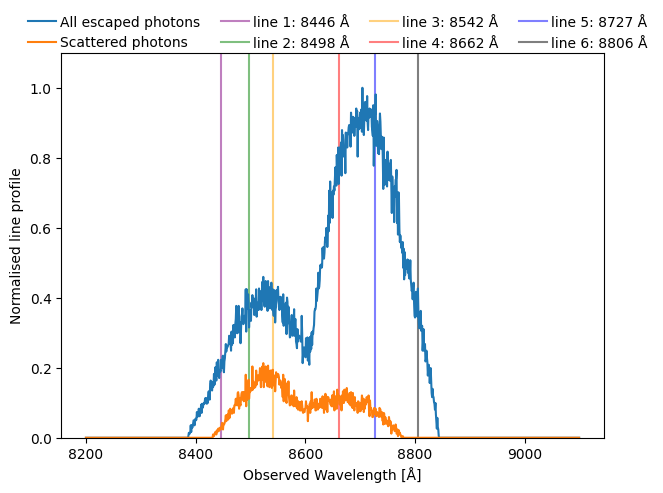

13it [01:01,  5.02s/it]

The following profile is now being created:


v_out: 4000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 50.0% 
Line 6: 8806.0 Å, tau = 1.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


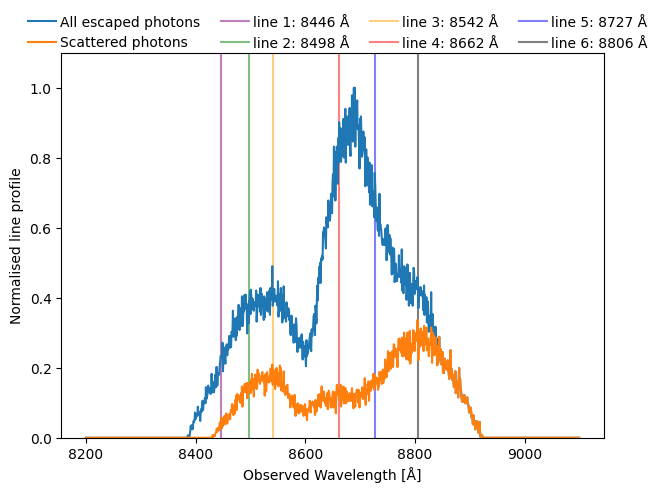

14it [01:06,  5.11s/it]

The following profile is now being created:


v_out: 4000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 50.0% 
Line 6: 8806.0 Å, tau = 2.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


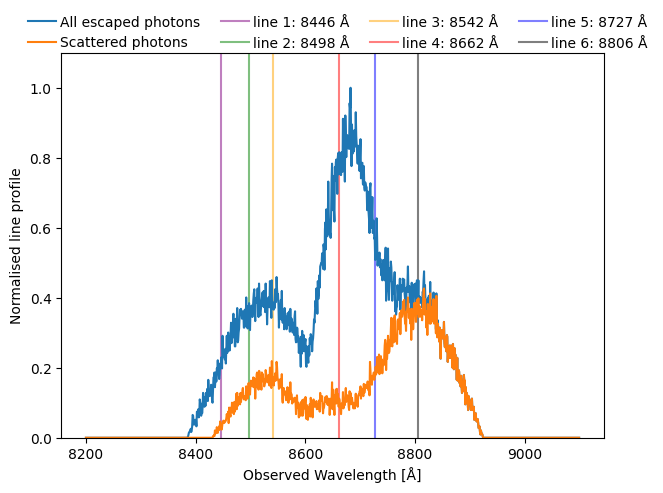

15it [01:11,  5.17s/it]

The following profile is now being created:


v_out: 4000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 62.5% 
Line 6: 8806.0 Å, tau = 0.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


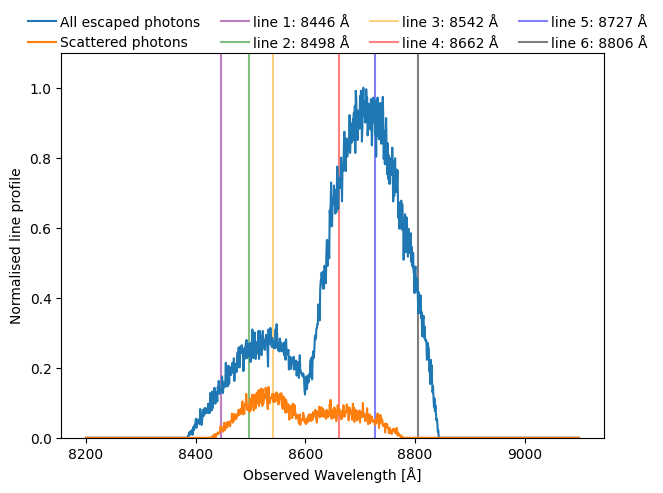

16it [01:16,  5.17s/it]

The following profile is now being created:


v_out: 4000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 62.5% 
Line 6: 8806.0 Å, tau = 1.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


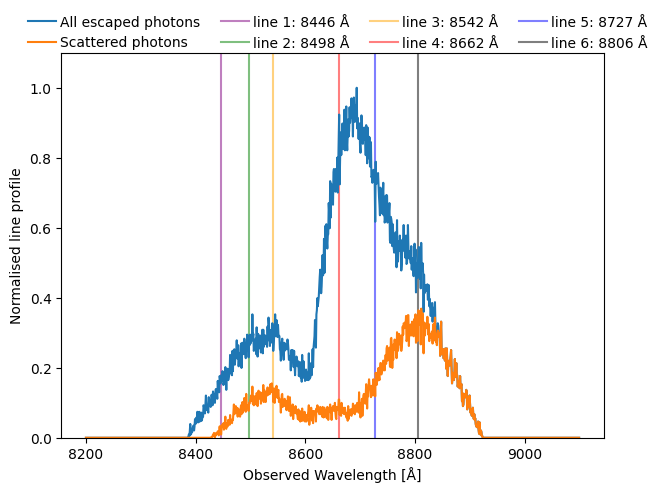

17it [01:22,  5.25s/it]

The following profile is now being created:


v_out: 4000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 62.5% 
Line 6: 8806.0 Å, tau = 2.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


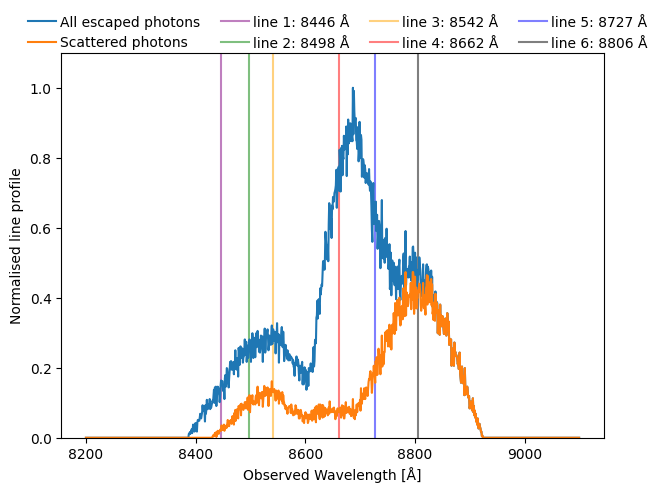

18it [01:27,  5.23s/it]

The following profile is now being created:


v_out: 4000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 70.0% 
Line 6: 8806.0 Å, tau = 0.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


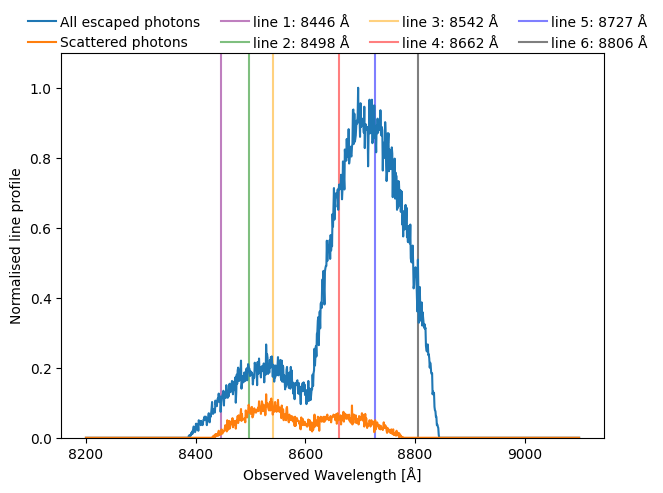

19it [01:32,  5.17s/it]

The following profile is now being created:


v_out: 4000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 70.0% 
Line 6: 8806.0 Å, tau = 1.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


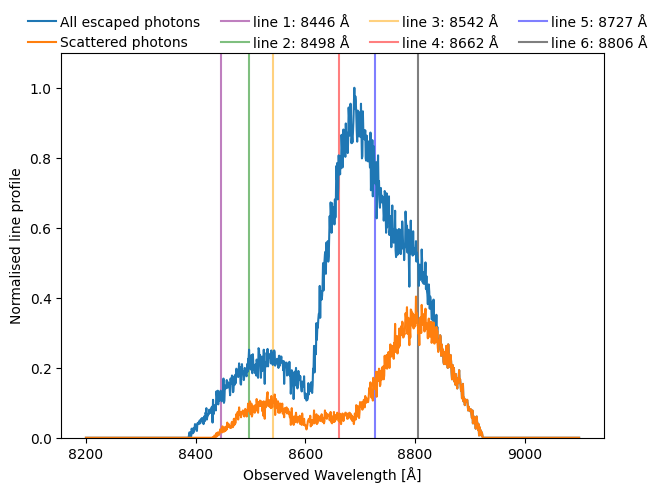

20it [01:37,  5.12s/it]

The following profile is now being created:


v_out: 4000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 70.0% 
Line 6: 8806.0 Å, tau = 2.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


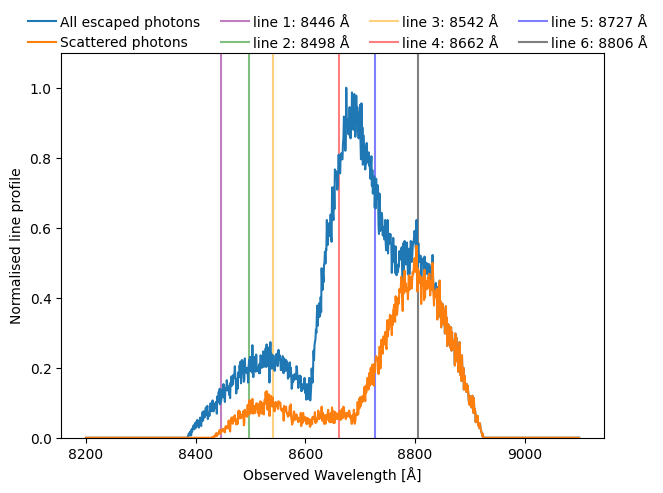

21it [01:42,  5.05s/it]

The following profile is now being created:


v_out: 4000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 76.9% 
Line 6: 8806.0 Å, tau = 0.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


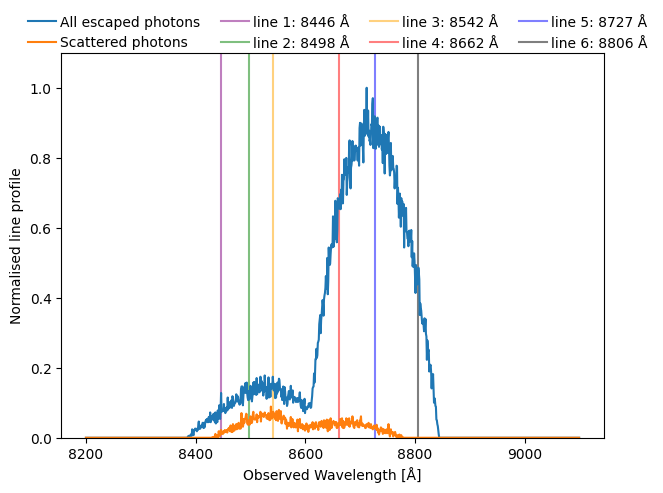

22it [01:47,  5.01s/it]

The following profile is now being created:


v_out: 4000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 76.9% 
Line 6: 8806.0 Å, tau = 1.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


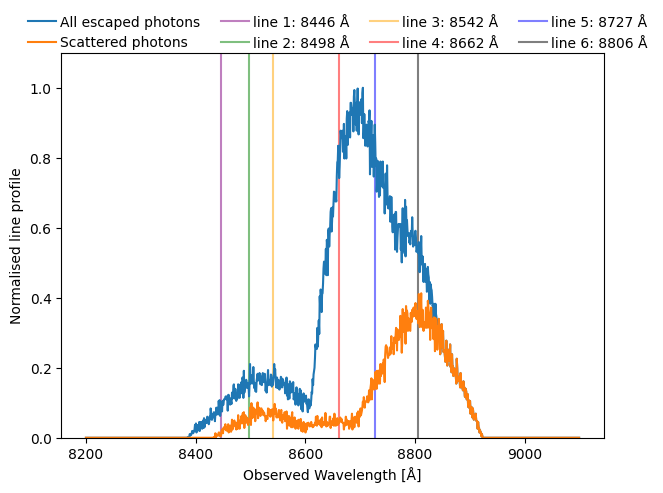

23it [01:52,  5.00s/it]

The following profile is now being created:


v_out: 4000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 76.9% 
Line 6: 8806.0 Å, tau = 2.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


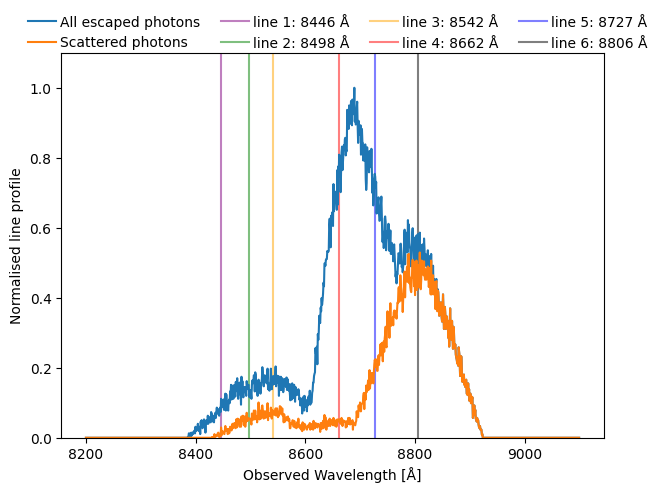

24it [01:57,  4.93s/it]

The following profile is now being created:


v_out: 5000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 50.0% 
Line 6: 8806.0 Å, tau = 0.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


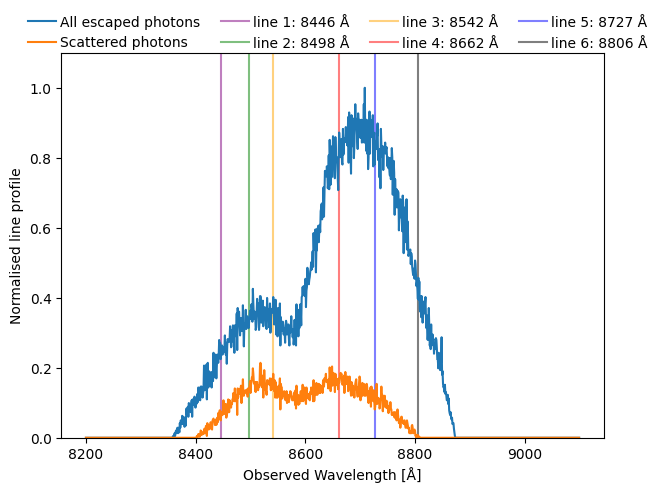

25it [02:02,  5.03s/it]

The following profile is now being created:


v_out: 5000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 50.0% 
Line 6: 8806.0 Å, tau = 1.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


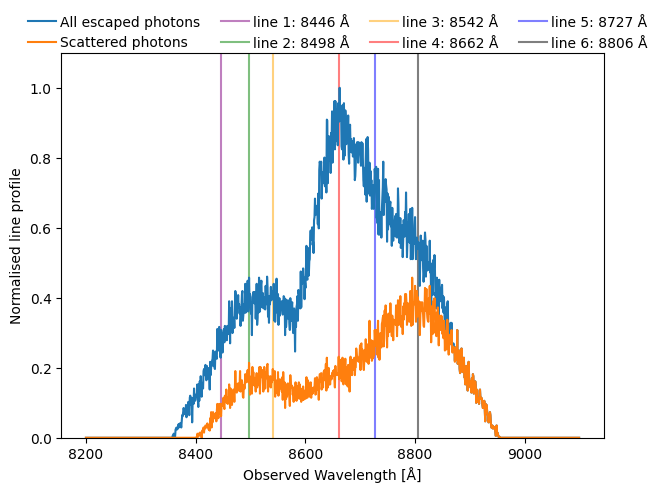

26it [02:07,  5.07s/it]

The following profile is now being created:


v_out: 5000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 50.0% 
Line 6: 8806.0 Å, tau = 2.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


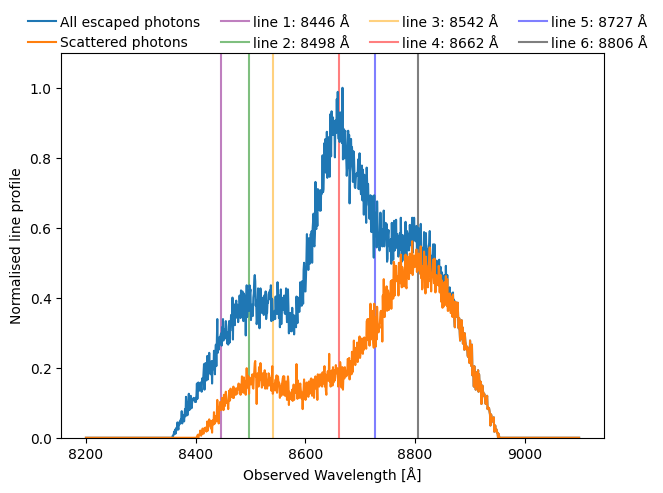

27it [02:13,  5.29s/it]

The following profile is now being created:


v_out: 5000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 62.5% 
Line 6: 8806.0 Å, tau = 0.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


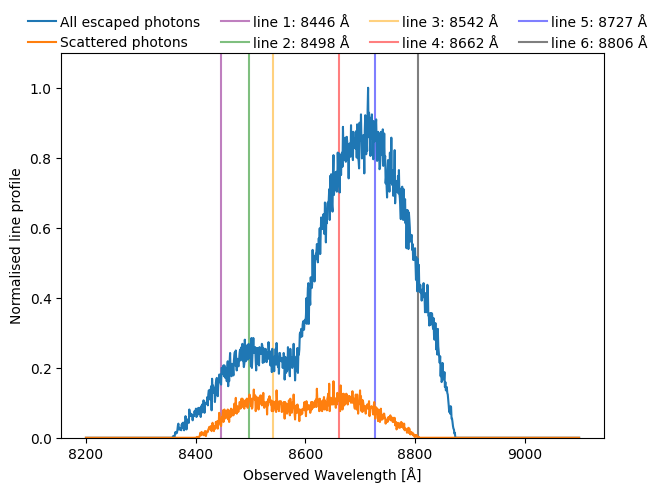

28it [02:18,  5.38s/it]

The following profile is now being created:


v_out: 5000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 62.5% 
Line 6: 8806.0 Å, tau = 1.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


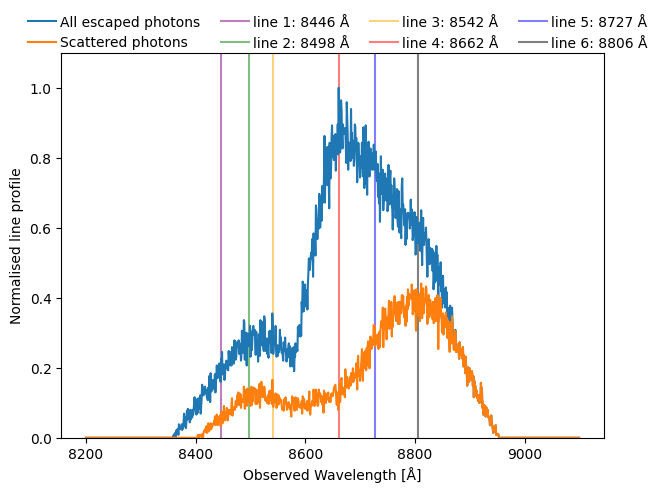

29it [02:24,  5.49s/it]

The following profile is now being created:


v_out: 5000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 62.5% 
Line 6: 8806.0 Å, tau = 2.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


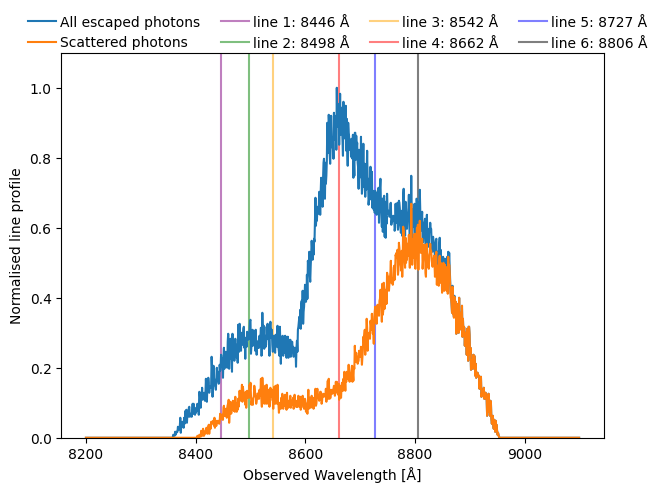

30it [02:29,  5.44s/it]

The following profile is now being created:


v_out: 5000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 70.0% 
Line 6: 8806.0 Å, tau = 0.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


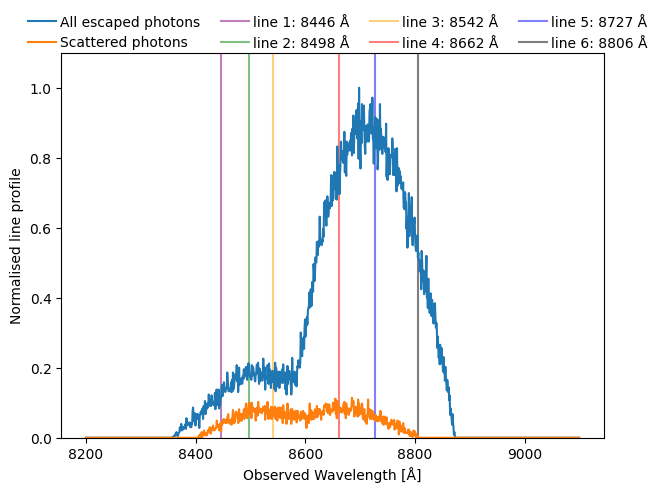

31it [02:35,  5.37s/it]

The following profile is now being created:


v_out: 5000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 70.0% 
Line 6: 8806.0 Å, tau = 1.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


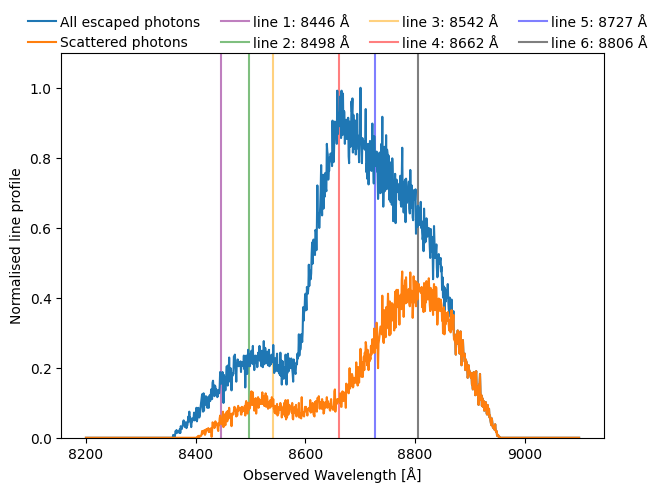

32it [02:40,  5.46s/it]

The following profile is now being created:


v_out: 5000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 70.0% 
Line 6: 8806.0 Å, tau = 2.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


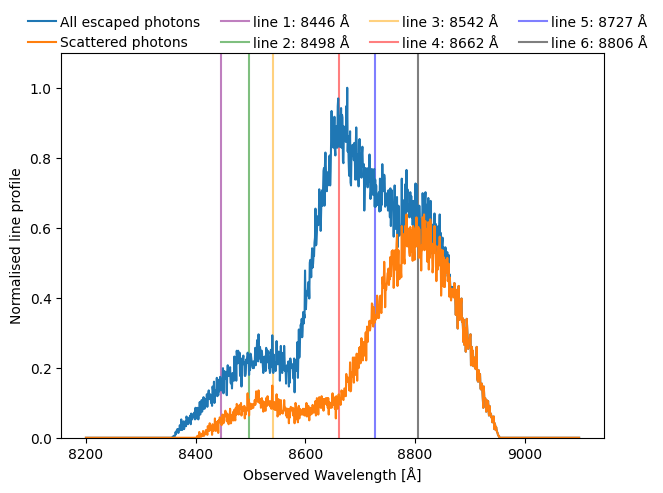

33it [02:46,  5.66s/it]

The following profile is now being created:


v_out: 5000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 76.9% 
Line 6: 8806.0 Å, tau = 0.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


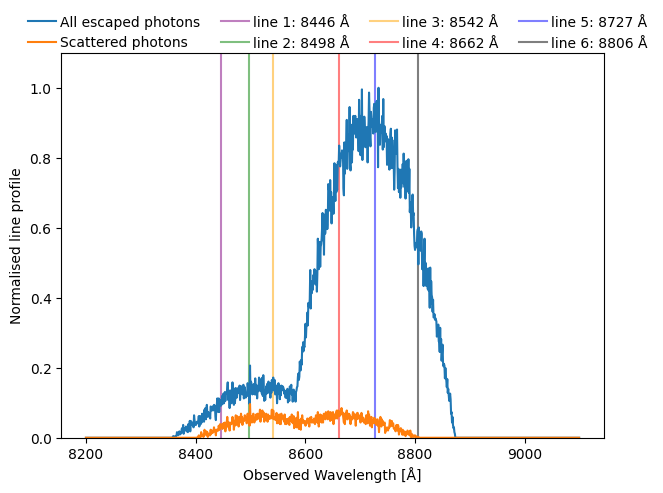

34it [02:52,  5.59s/it]

The following profile is now being created:


v_out: 5000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 76.9% 
Line 6: 8806.0 Å, tau = 1.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


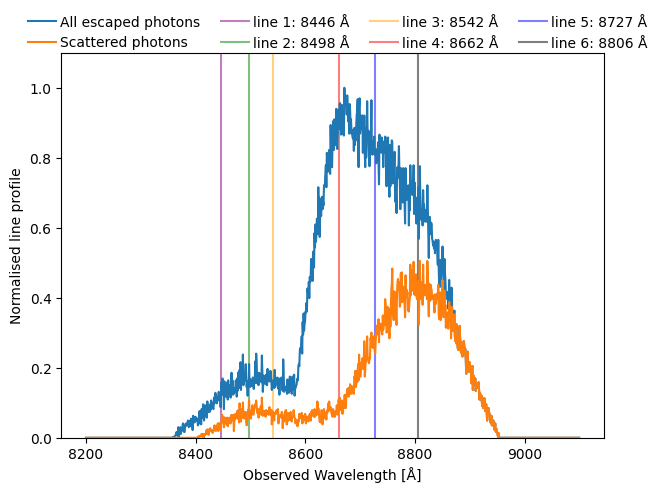

35it [02:57,  5.57s/it]

The following profile is now being created:


v_out: 5000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 76.9% 
Line 6: 8806.0 Å, tau = 2.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


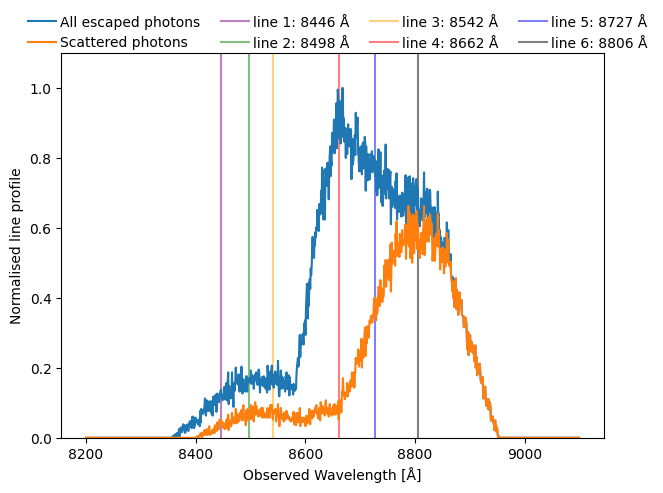

36it [03:03,  5.54s/it]

The following profile is now being created:


v_out: 6000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 50.0% 
Line 6: 8806.0 Å, tau = 0.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


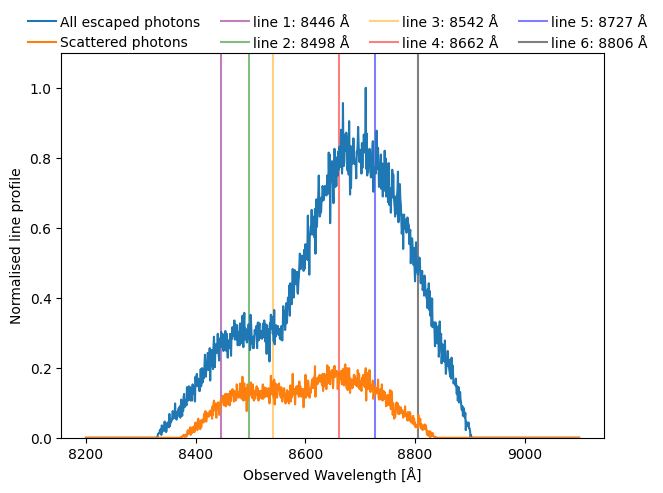

37it [03:09,  5.68s/it]

The following profile is now being created:


v_out: 6000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 50.0% 
Line 6: 8806.0 Å, tau = 1.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


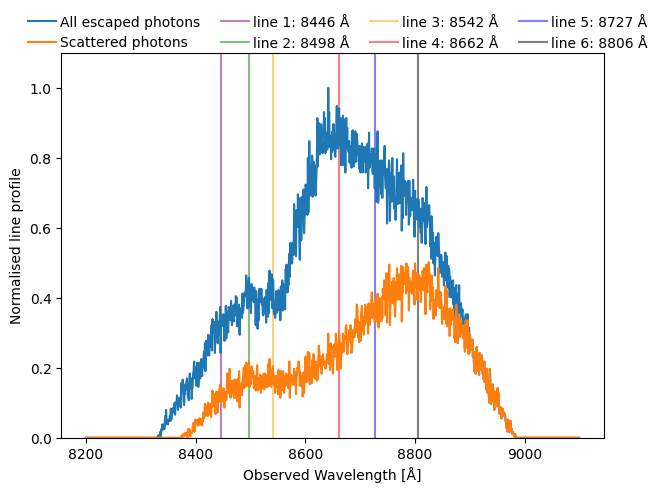

38it [03:15,  5.82s/it]

The following profile is now being created:


v_out: 6000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 16.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 50.0% 
Line 6: 8806.0 Å, tau = 2.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


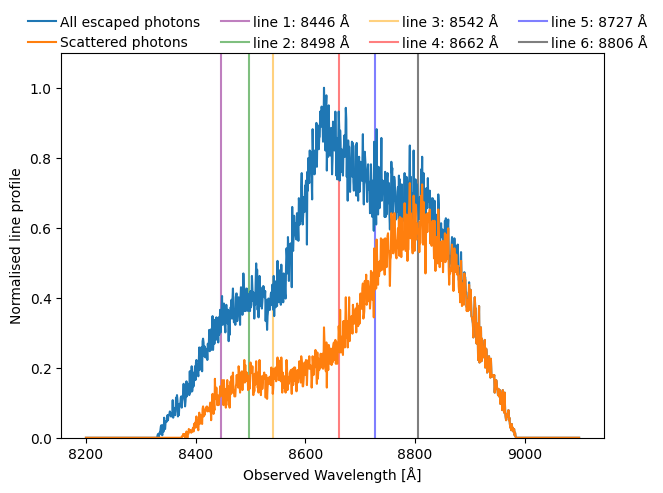

39it [03:21,  5.92s/it]

The following profile is now being created:


v_out: 6000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 62.5% 
Line 6: 8806.0 Å, tau = 0.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


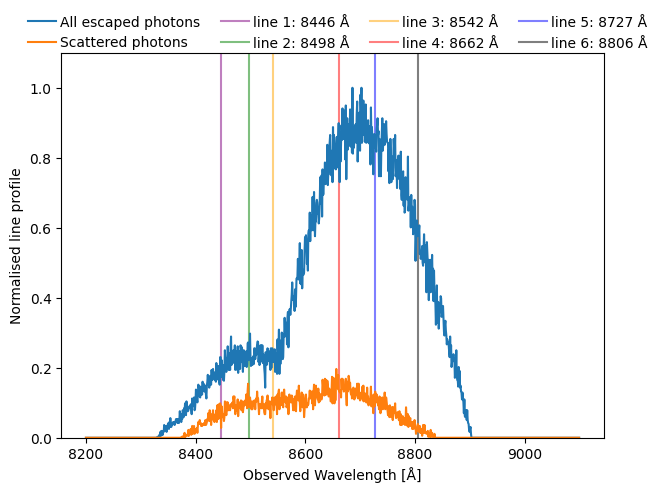

40it [03:27,  5.93s/it]

The following profile is now being created:


v_out: 6000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 62.5% 
Line 6: 8806.0 Å, tau = 1.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


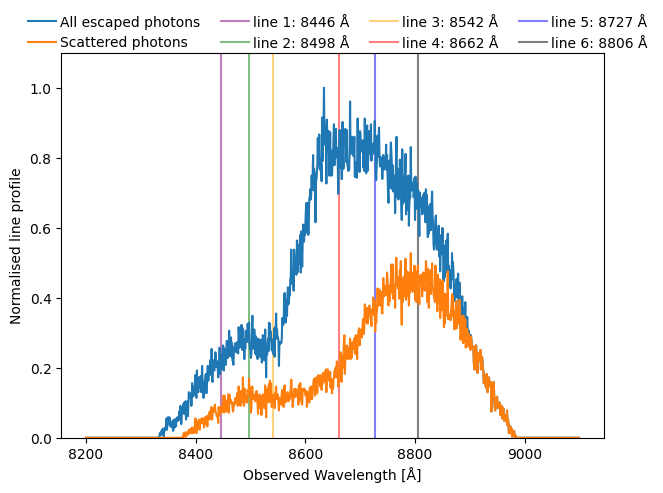

41it [03:33,  6.05s/it]

The following profile is now being created:


v_out: 6000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 12.5% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 62.5% 
Line 6: 8806.0 Å, tau = 2.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


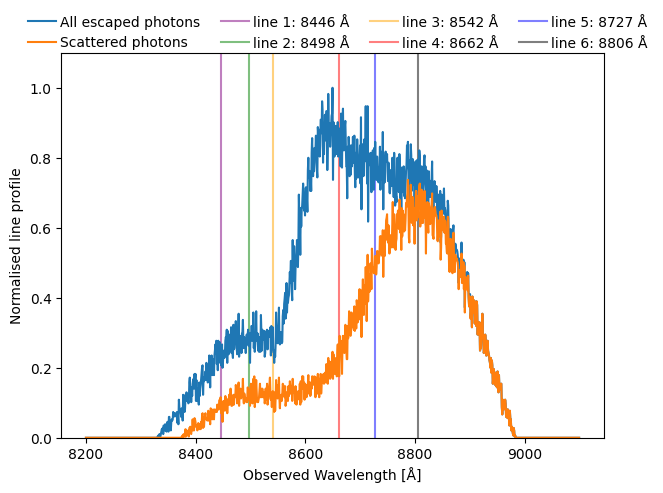

42it [03:40,  6.22s/it]

The following profile is now being created:


v_out: 6000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 70.0% 
Line 6: 8806.0 Å, tau = 0.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


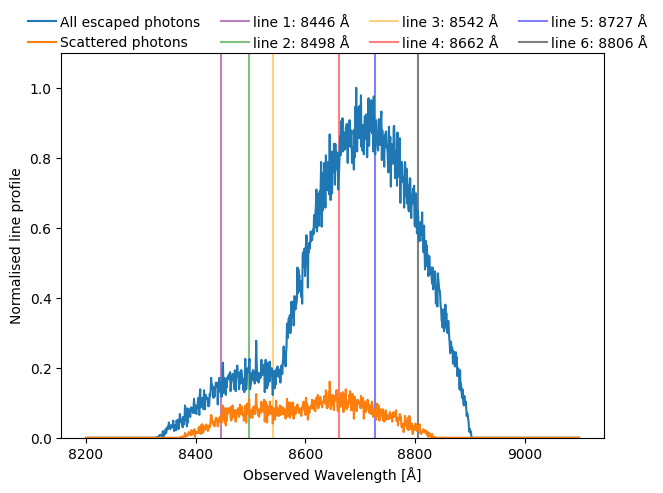

43it [03:46,  6.12s/it]

The following profile is now being created:


v_out: 6000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 70.0% 
Line 6: 8806.0 Å, tau = 1.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


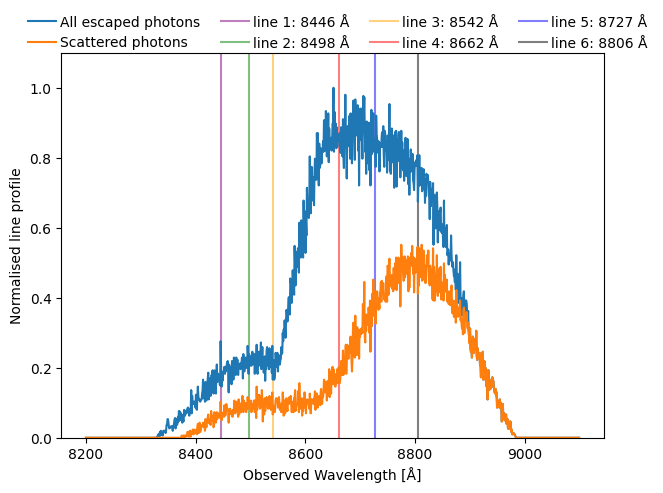

44it [03:52,  6.06s/it]

The following profile is now being created:


v_out: 6000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 70.0% 
Line 6: 8806.0 Å, tau = 2.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


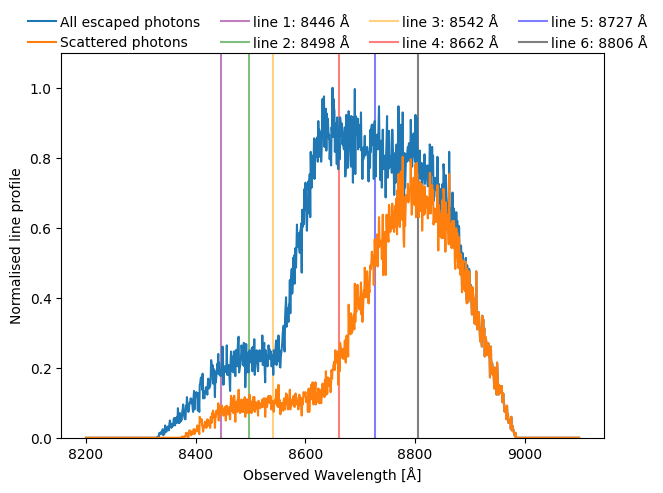

45it [03:58,  5.94s/it]

The following profile is now being created:


v_out: 6000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 76.9% 
Line 6: 8806.0 Å, tau = 0.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


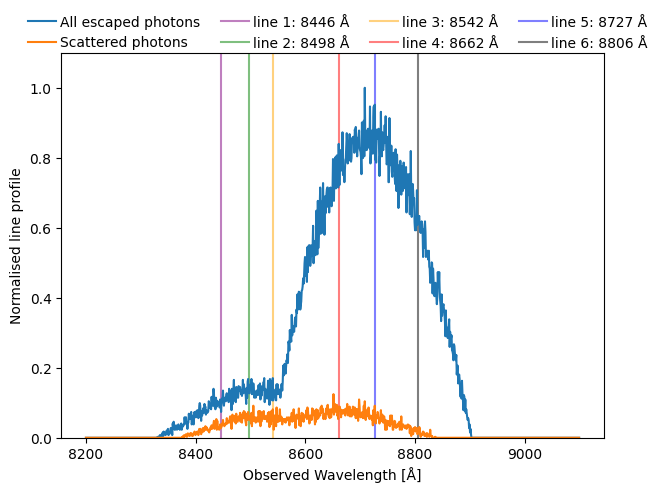

46it [04:03,  5.88s/it]

The following profile is now being created:


v_out: 6000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 76.9% 
Line 6: 8806.0 Å, tau = 1.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


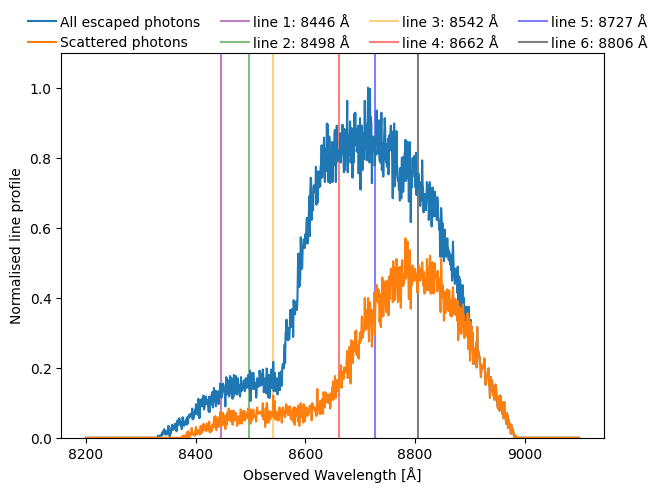

47it [04:09,  5.92s/it]

The following profile is now being created:


v_out: 6000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 7.7% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 76.9% 
Line 6: 8806.0 Å, tau = 2.00e+00, normalised luminosity: 0.0% 
Collected photons:  100.0 %
Destroyed photons:  0.0 %
Scattering death photons:  0.0 %


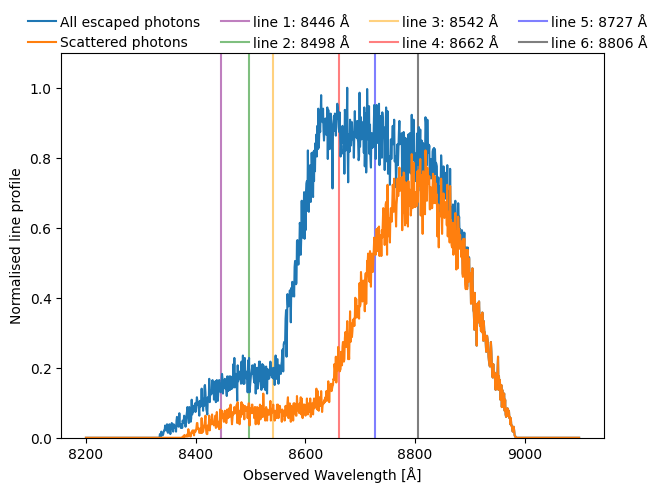

48it [04:15,  5.32s/it]


In [10]:
if 'profile_library' not in os.listdir(os.getcwd()): # Create a folder to store the line profiles
    os.mkdir('profile_library')
    print("The folder 'profile_library' was not found, so it has been created.")

N_combinations = prod(len(sub) for sub in master_list) # Get the total number of requested line profiles
print("You requested a total of ", N_combinations, ' line profiles to be created. Starting now!')

# The main loop
for free_parameter_combination in tqdm(itertools.product(*master_list)):
    
    middle_master_index = int((len(master_list)+1)/2) # Get the index from which we have tau lists, below el lists
    
    # Set the free parameters for this combination
    
    v_out = free_parameter_combination[0]
    rin = v_lim/v_out # Define the inner, photospheric radius
    
    lum_vec = free_parameter_combination[1:middle_master_index] # Define the relative luminosities of each line
    lum_vec = lum_vec/np.sum(lum_vec) # Normalise the luminosity vector
    
    for i in range(middle_master_index, len(free_parameter_combination)):
        if free_parameter_combination[i] != None: # If this line should have varying optical depth
            tau_vec[i-middle_master_index] = free_parameter_combination[i] # Set the optical depth to something new

    line_profile_name = chf.extract_line_profile_fname(v_out, lum_vec, tau_vec, wllines, line_shape) # Get profile name
    
    print("The following profile is now being created:\n")
    chf.profile_info(v_out, lum_vec, tau_vec, wllines) # Give info on the profile that will be created
    
    already_created_names = os.listdir(os.getcwd() + '/profile_library/') # Get all names that exist

    if line_profile_name in already_created_names: # If the profile already exists...
        print('This profile already exists! Continuing with the next one ...')
        continue

    n_destroyed, n_scatterdeath = 0, 0
    hist = np.zeros(N_bin)
    histscatt = np.zeros(N_bin)

    for i in range(N_mc): # For each photon packet

        # Initialise photon packet state
        scattered = False
        escaped = False
        destroyed = False
        n_scatters = 0

        # Get the starting wavelength, angle of the packet
        wl, mu, r = rt.draw_random_photon(wllines, line_shape, lum_vec, wlmin, wlmax)
        sin_theta = np.sqrt(1 - mu**2)


        while (escaped == False and destroyed == False): # While the packet is alive

            # Compute distance to outer shell edge:
            distouter = -r*mu + np.sqrt((r*mu)**2 - (r**2 - 1**2))

            # Compute distance to inner shell edge:
            if (mu < 0 and r*sin_theta < rin):
                distinner = -r*mu - np.sqrt((r*mu)**2 - (r**2 - rin**2))
            else:
                distinner = 2.

            # Now calculate the distance to the next scattering line

            redward_indices = (wllines > wl) # Get all lines redward of here
            if (any(redward_indices)):
                ind_closest_line = np.where(wllines == wllines[redward_indices][0])[0][0]
                wl_closest = wllines[ind_closest_line]
                distscatt = ( (wl_closest - wl) / wl ) * (c/v_out) # Note: this is normalised to the outer radius at v_out (max(distscatt) = 2)
            else: 
                distscatt = np.inf #No redward line remaining, so no interaction

            # Update sintheta
            sin_theta = np.sqrt(1.-mu**2)
            
            # The if-block below checks if we have a) scattering b) escape c) inner shell hit

            if (distscatt < distouter and distscatt < distinner): # If distance to interaction is smaller than to both shell edges..
                n_scatters += 1
                wl, r, mu, sin_theta, destroyed, scattered = rt.check_interaction(distscatt, wl, mu, r, sin_theta, v_out, T, tau_vec, destrprob, ind_closest_line, destroyed, scattered)

            elif (distouter < distinner): # Next event is hitting outer shell edge..:  
                escaped, hist, histscatt = rt.do_escape(distouter, wl, r, mu, sin_theta, v_out, scattered, hist, histscatt, binarr)

            else: # Next event is hitting inner shell edge
                destroyed = True #Does it die?
                n_destroyed += 1

            #=====================================================================================
            #As we currently only allow destrprob = 0, photons can get trapped around line wavelength, scattering forever. This if-statement avoids that
            if n_scatters > 50:
                destroyed = True

                n_scatterdeath += 1

    if save_profiles == True:
        data_array = np.zeros((len(binarr), 2))
        data_array[:, 0] = binarr
        data_array[:, 1] = hist/np.max(hist) # Normalise it for easier comparison
        
        np.savetxt(os.getcwd() + '/profile_library/' + line_profile_name, data_array, delimiter = ',')

    if verbose == True:
        
        chf.plot_result(hist, histscatt, binarr, wllines, tau_vec, N_mc, n_destroyed, n_scatterdeath)